In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/home-credit-default-risk')

In [4]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

In [6]:
# 종속변수 클래스 불균형 체크 -> 불균형 존재.. metric을 accuracy가 아닌 AUC 살펴보기
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:>

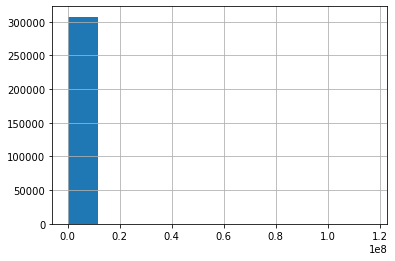

In [7]:
# AMT_INCOME_TOTAL 히스토그램, distplot 살펴보기
app_train['AMT_INCOME_TOTAL'].hist()

<AxesSubplot:>

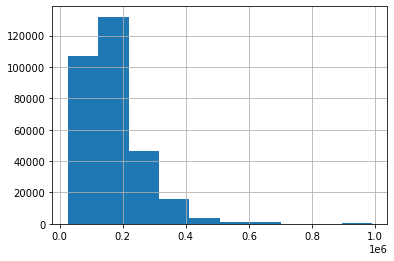

In [19]:
# AMT_INCOME_TOTAL 값을 특정 값 이하의 데이터로 필터링한 후 분포도 관찰
app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'].hist()

<AxesSubplot:xlabel='AMT_INCOME_TOTAL'>

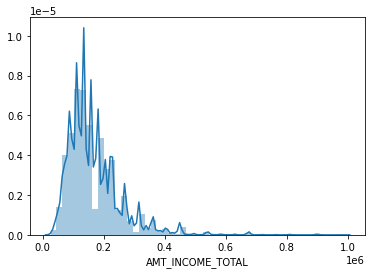

In [22]:
# distplot으로 그려보기
df = app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL']
sns.distplot(df)

<AxesSubplot:xlabel='AMT_INCOME_TOTAL'>

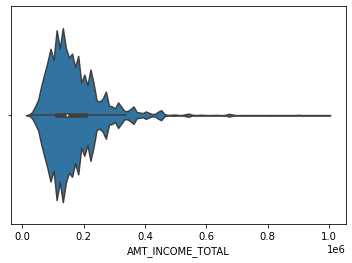

In [23]:
# Violinplot 그려보기
sns.violinplot(df)

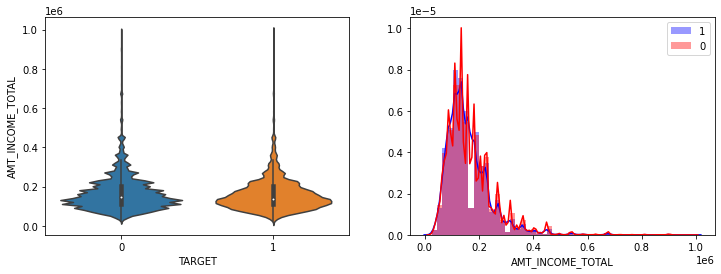

In [28]:
# Target 값에 따라 분류한 후 Violinplot, distplot 그려보기
cond1 = app_train['TARGET'] == 1
cond0 = app_train['TARGET'] == 0
cond_ = app_train['AMT_INCOME_TOTAL'] < 1000000

fig, axes = plt.subplots(figsize=(12, 4),
                        nrows=1, ncols=2)
data = app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]
sns.violinplot(x='TARGET', y='AMT_INCOME_TOTAL',
              data=data, ax=axes[0])
sns.distplot(app_train[cond1 & cond_]['AMT_INCOME_TOTAL'],
            label='1', color='blue', ax=axes[1])
sns.distplot(app_train[cond0 & cond_]['AMT_INCOME_TOTAL'],
            label='0', color='red', ax=axes[1])
axes[1].legend(loc='upper right')

In [29]:
# train, test 데이터 합치기
apps = pd.concat([app_train, app_test], axis=0)
apps.shape

(356255, 122)

In [33]:
# Object 형 변수 Label encoding 시키기
# Pandas의 factorize 이용!
object_columns = apps.dtypes[apps.dtypes == 'object'].index

In [38]:
# 예시로 한 변수만 factorize 이용해서 label encoding 수행
# factorize는 튜플 형태로 객체 반환!
pd.factorize(apps['NAME_CONTRACT_TYPE'])[0]

array([0, 0, 1, ..., 0, 0, 0])

In [39]:
# for문을 이용해 object 변수들 레이블 인코딩 수행
object_columns = apps.dtypes[apps.dtypes == 'object'].index

for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

In [40]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(56)
memory usage: 334.3 MB


In [41]:
# 결측치 -999로 대체
apps = apps.fillna(-999)
apps.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 122, dtype: int64

In [43]:
# train, test 재분리 -> TARGET의 값을 기준으로 분리
apps_train = apps[apps['TARGET'] != -999]
apps_test = apps[apps['TARGET'] == -999]
apps_train.shape, apps_test.shape

((307511, 122), (48744, 122))

In [45]:
# Test 데이터 TARGET 값 지워주기
apps_test.drop(['TARGET'], axis=1, inplace=True)

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [47]:
apps_test = apps_test.drop(['SK_ID_CURR'], axis=1)

In [48]:
# Light GBM은 Validation 데이터를 인자로 넣어주면 검증 절차 진행해줌
# 따라서 apps_train 데이터에서 train, validation 데이터로 구분하기
from sklearn.model_selection import train_test_split

train_ftr = apps_train.drop(['SK_ID_CURR','TARGET'], axis=1)
train_target = apps_train['TARGET']

X_train, X_valid, y_train, y_valid = train_test_split(train_ftr,
                                                     train_target,
                                                     test_size=0.3,
                                                     random_state=42)
X_train.shape, X_valid.shape

((215257, 120), (92254, 120))

In [50]:
# Light GBM 으로 모델링
from lightgbm import LGBMClassifier

rgb_clf = LGBMClassifier(n_estimators=500,
                        learning_rate=0.02,
                        num_leaves=32,
                        subsample=0.8,
                        max_depth=12,
                        silent=-1,
                        verbose=-1,
                        n_jobs=-1)

# 학습 & 검증
rgb_clf.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_valid, y_valid)],
           eval_metric='auc', verbose=100, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.75225	training's binary_logloss: 0.250332	valid_1's auc: 0.740872	valid_1's binary_logloss: 0.251858
[200]	training's auc: 0.771524	training's binary_logloss: 0.243653	valid_1's auc: 0.751551	valid_1's binary_logloss: 0.247887
[300]	training's auc: 0.78527	training's binary_logloss: 0.239394	valid_1's auc: 0.755899	valid_1's binary_logloss: 0.246415
[400]	training's auc: 0.796899	training's binary_logloss: 0.235954	valid_1's auc: 0.757394	valid_1's binary_logloss: 0.245897
[500]	training's auc: 0.806535	training's binary_logloss: 0.233061	valid_1's auc: 0.75813	valid_1's binary_logloss: 0.245648
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.806535	training's binary_logloss: 0.233061	valid_1's auc: 0.75813	valid_1's binary_logloss: 0.245648


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=500,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

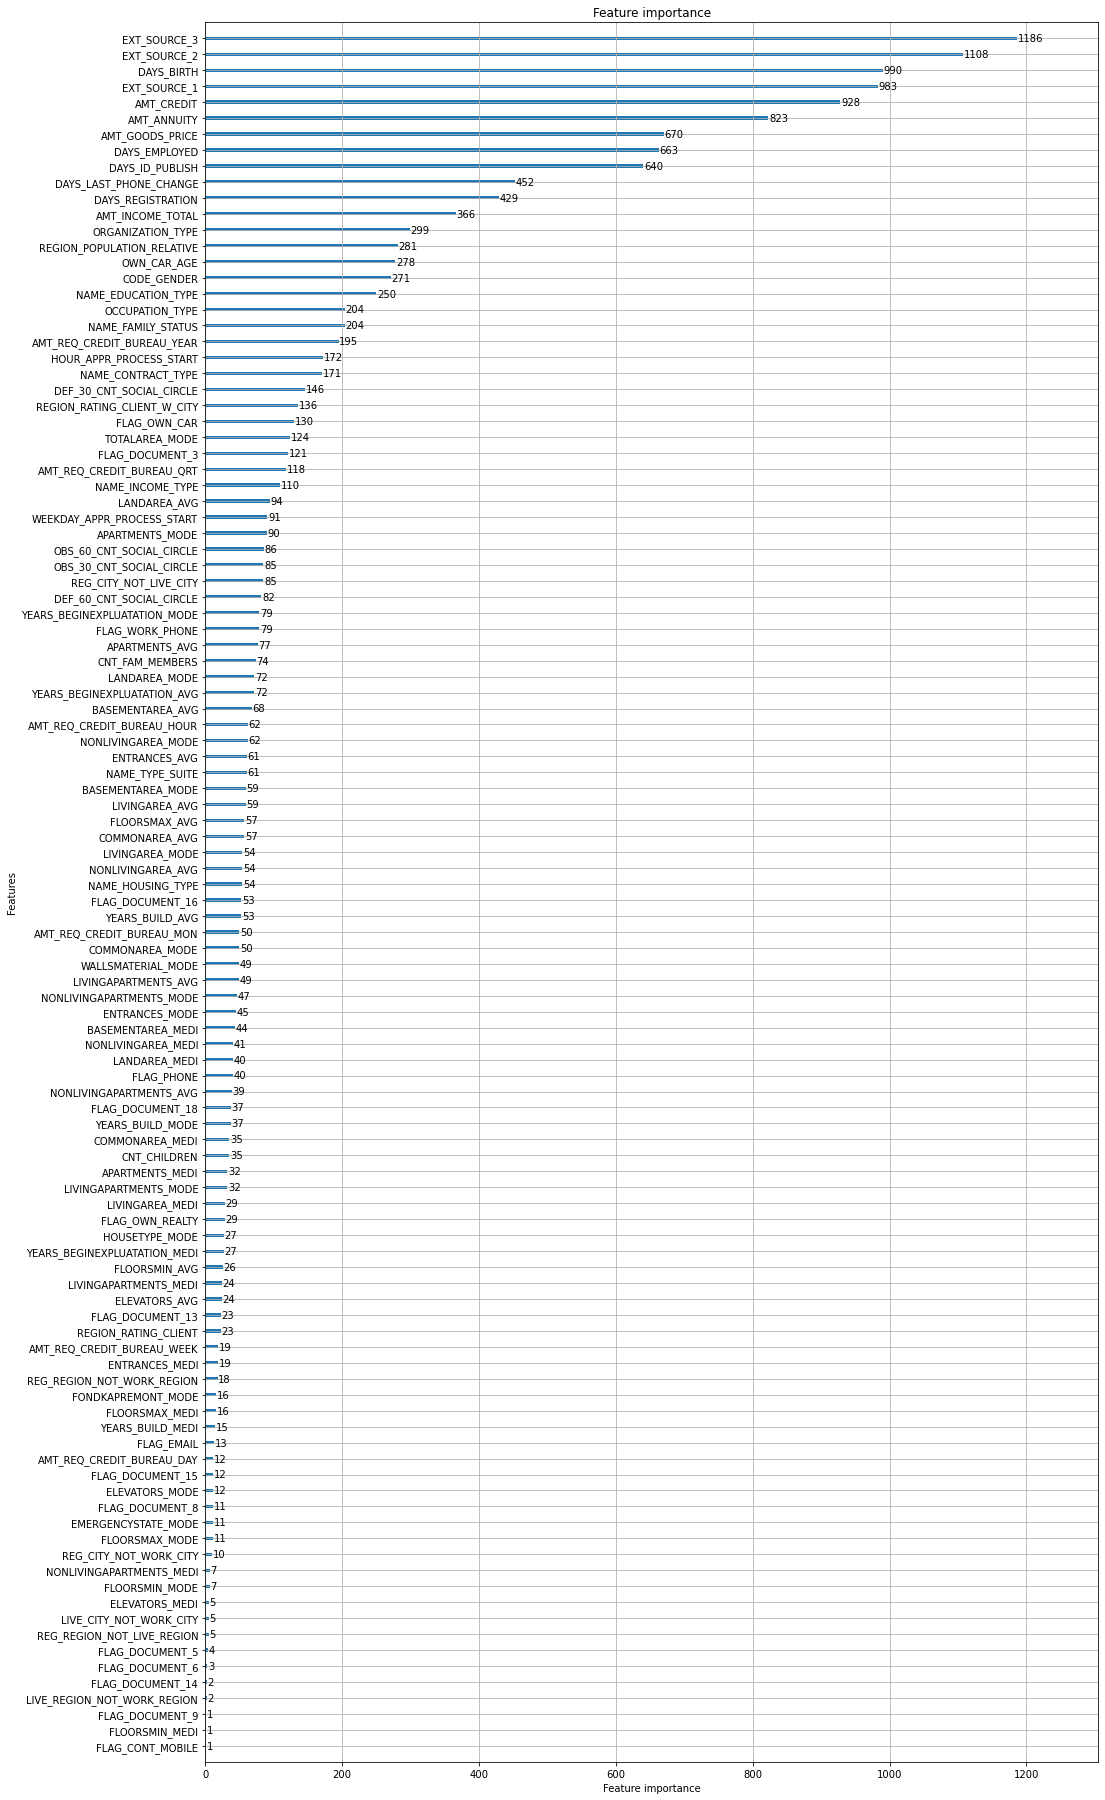

In [51]:
# Importance plot
from lightgbm import plot_importance

plot_importance(rgb_clf, figsize=(16, 32))

In [53]:
# Kaggle에 제출해보기
preds = rgb_clf.predict_proba(apps_test)[:,1]

In [59]:
result = app_test.loc[:,['SK_ID_CURR']]
result['TARGET'] = preds
result.head()

,SK_ID_CURR,TARGET
0,100001,0.036907
1,100005,0.108567
2,100013,0.018081
3,100028,0.033042
4,100038,0.172336


In [61]:
result.to_csv('/Users/younghun/Desktop/baseline_test.csv',
             index=False)